# Week 9: Dropout

In [1]:
# Load the dataset...
import torch
from pathlib import Path
from torch import nn
import sys
import numpy as np
from sklearn.datasets import fetch_openml
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

%matplotlib notebook

if("dataset" not in globals()):
    root_dir = Path().resolve()
    dataset = torchvision.datasets.MNIST(root_dir, download=True, transform=transforms.ToTensor())
    train, test = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

First, load in MNIST and display a character:

Image Size: (1, 28, 28)


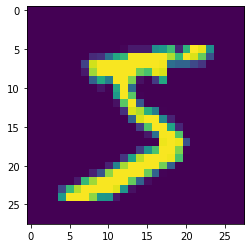

In [2]:
%matplotlib inline
print("Image Size:", tuple(dataset[0][0].shape))
plt.imshow(dataset[0][0].moveaxis(0, -1))

In [3]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cpu


In [4]:
batch_size = 100

to_device = lambda a: a.to(device)

test_loader = torch.utils.data.DataLoader(test, batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)

In [5]:
# Functions for training a model...
def train_model(
    model, 
    train_data, 
    test_data, 
    optimizer, 
    error_func, 
    n_epochs,
    device,
    print_every=100,
    print_accuracy=True
):
    for epoch_i in range(1, n_epochs + 1):
        model.train()
        for i, (img, label) in enumerate(train_data, 1):
            # Zero gradients...
            model.zero_grad()
            # Run model...
            predicted = model.forward(img.to(device))
            
            # Compute loss, backpropigate, and optimize the weights...
            loss = error_func(predicted, label.to(device))
            loss.backward()
            optimizer.step()
            
            if((i % print_every == 0) or (i == len(train_data))):
                print(f"Epoch: {epoch_i}/{n_epochs}, Iter: {i}/{len(train_data)}, Loss: {loss:.04f}")
                
        # Run against the test set and train set at the end of each epoch to get accuracy...
        if(print_accuracy):
            model.eval()
            acc1 = get_accuracy(model, train_data)
            print(f"Epoch {epoch_i} Train Accuracy: {acc1 * 100:.02f}%")
            acc2 = get_accuracy(model, test_data)
            print(f"Epoch {epoch_i} Test Accuracy: {acc2 * 100:.02f}%\n")
    
    return model
        
        
def get_accuracy(model, data):
        run = 0
        correct = 0
        
        for img, label in data:
            run += len(img)
            result = model.forward(img.to(device)).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

### Model Without Dropout

Our first model will be a regular MLP classifying MNIST digits without dropout. Recall that in this network, all neurons (or nodes) will be present for every training case.

In [6]:
class VanillaNN(nn.Module):
    def __init__(self, input_size: tuple, hidden_layer_sizes: list, class_count: int): 
        super().__init__()
        layers = [
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]):
            layers.extend([
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.append(nn.Linear(hidden_layer_sizes[-1], class_count))
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 2]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 2](x.reshape(x.shape[0], -1))

In [7]:
#TODO: Below, set the number of hidden units per layer and number of output classes
hidden_layers = [60, 60, 60] # this should be an array with units per hidden layer
num_classes = 10

vnn = VanillaNN(dataset[0][0].shape, hidden_layers, num_classes).to(device)
print(vnn)

VanillaNN(
  (_linear_layers): Sequential(
    (0): Linear(in_features=784, out_features=60, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=60, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [8]:
# TODO: Set epochs and learning rate. Be sure the network's performance has begun to plateau for a good comparison
n_epochs = 15
lr = 1e-3

# Set up everything...
optimizer = optim.Adam(vnn.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

In [9]:
vnn = train_model(vnn, train_loader, test_loader, optimizer, loss_func, n_epochs, device)

Epoch: 1/15, Iter: 100/480, Loss: 1.7071
Epoch: 1/15, Iter: 200/480, Loss: 1.6753
Epoch: 1/15, Iter: 300/480, Loss: 1.6458
Epoch: 1/15, Iter: 400/480, Loss: 1.5987
Epoch: 1/15, Iter: 480/480, Loss: 1.5445
Epoch 1 Train Accuracy: 90.38%
Epoch 1 Test Accuracy: 90.32%

Epoch: 2/15, Iter: 100/480, Loss: 1.5838
Epoch: 2/15, Iter: 200/480, Loss: 1.5765
Epoch: 2/15, Iter: 300/480, Loss: 1.5334
Epoch: 2/15, Iter: 400/480, Loss: 1.5621
Epoch: 2/15, Iter: 480/480, Loss: 1.5379
Epoch 2 Train Accuracy: 92.75%
Epoch 2 Test Accuracy: 92.59%

Epoch: 3/15, Iter: 100/480, Loss: 1.5119
Epoch: 3/15, Iter: 200/480, Loss: 1.5077
Epoch: 3/15, Iter: 300/480, Loss: 1.5025
Epoch: 3/15, Iter: 400/480, Loss: 1.5466
Epoch: 3/15, Iter: 480/480, Loss: 1.5292
Epoch 3 Train Accuracy: 93.43%
Epoch 3 Test Accuracy: 92.67%

Epoch: 4/15, Iter: 100/480, Loss: 1.5617
Epoch: 4/15, Iter: 200/480, Loss: 1.4948
Epoch: 4/15, Iter: 300/480, Loss: 1.5247
Epoch: 4/15, Iter: 400/480, Loss: 1.5066
Epoch: 4/15, Iter: 480/480, Loss: 1

In [10]:
print(f"Final Model Test Accuracy: {get_accuracy(vnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 96.12%


### Model With Dropout

Now, let's try the same network with dropout. Dropout is simple: For every layer, the input to any given neuron is zeroed out with probability *p*. When a neuron's input is zeroed out, it's effectively removed from the model. Which neurons are dropped are determined by a vector of 1's and 0's generated by a Bernoulli distribution (at least, in the paper) for each training case.

Notably, dropout effectively turns a single model into an ensemble of models that share weights, where each model in the ensemble is a random subnetwork that only rarely gets trained.

**TODO: How many subnetworks are possible in a network with *n* units?**

**TODO: How does dropout change the relationship of units in the network with their neighbors?**

In [11]:
class DropoutNN(nn.Module):
    def __init__(
        self, 
        input_size: tuple, 
        hidden_layer_sizes: list, 
        dropout_values: list, 
        class_count: int
    ):
        super().__init__()
        layers = [
            #TODO: Add dropout here (hint: there's a PyTorch function for it).
            #Which value from the dropout list should go here?
            nn.Dropout(dropout_values[0]),
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size, dv in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:], dropout_values[1:]):
            layers.extend([
                #TODO: Add dropout here too
                nn.Dropout(dv),
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.extend([
            #TODO: Last dropout call here. Which value should it take?
            nn.Dropout(dropout_values[-1]),
            nn.Linear(hidden_layer_sizes[-1], class_count)
        ])
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 3 + 1]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 3](x.reshape(x.shape[0], -1))

In [12]:
# TODO: Specify number of hidden units per layer, per-layer dropout probability (between 0 and 1), and number of 
# output classes. How many per-layer dropout probabilities does this model require?
hidden_layers = [60, 60, 60] # same as vanilla
dropout_probs = [0.5, 0.5, 0.5, 0.5] # 4 dropouts, num of hidden layers + 1
num_classes = 10

dnn = DropoutNN(dataset[0][0].shape, hidden_layers, dropout_probs, num_classes).to(device)
print(dnn)

DropoutNN(
  (_linear_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=784, out_features=60, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=60, out_features=60, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=60, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [13]:
# TODO: Set epochs and learning rate. Note that dropout substantially slows down training!
n_epochs2 = 15
lr2 = 1e-3

# Set up everything...
optimizer2 = optim.Adam(dnn.parameters(), lr=lr2)
loss_func2 = nn.CrossEntropyLoss()

In [14]:
dnn = train_model(dnn, train_loader, test_loader, optimizer2, loss_func2, n_epochs2, device)

Epoch: 1/15, Iter: 100/480, Loss: 2.1665
Epoch: 1/15, Iter: 200/480, Loss: 2.0256
Epoch: 1/15, Iter: 300/480, Loss: 1.8269
Epoch: 1/15, Iter: 400/480, Loss: 1.7849
Epoch: 1/15, Iter: 480/480, Loss: 1.8552
Epoch 1 Train Accuracy: 76.91%
Epoch 1 Test Accuracy: 76.43%

Epoch: 2/15, Iter: 100/480, Loss: 1.7989
Epoch: 2/15, Iter: 200/480, Loss: 1.7560
Epoch: 2/15, Iter: 300/480, Loss: 1.7129
Epoch: 2/15, Iter: 400/480, Loss: 1.7082
Epoch: 2/15, Iter: 480/480, Loss: 1.7054
Epoch 2 Train Accuracy: 88.02%
Epoch 2 Test Accuracy: 87.63%

Epoch: 3/15, Iter: 100/480, Loss: 1.6785
Epoch: 3/15, Iter: 200/480, Loss: 1.6430
Epoch: 3/15, Iter: 300/480, Loss: 1.6482
Epoch: 3/15, Iter: 400/480, Loss: 1.6567
Epoch: 3/15, Iter: 480/480, Loss: 1.6636
Epoch 3 Train Accuracy: 89.57%
Epoch 3 Test Accuracy: 89.56%

Epoch: 4/15, Iter: 100/480, Loss: 1.6518
Epoch: 4/15, Iter: 200/480, Loss: 1.6519
Epoch: 4/15, Iter: 300/480, Loss: 1.6316
Epoch: 4/15, Iter: 400/480, Loss: 1.6671
Epoch: 4/15, Iter: 480/480, Loss: 1

In [15]:
dnn.eval()
print(f"Final Model Test Accuracy: {get_accuracy(dnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 92.23%


In the interest of time: if the dropout model performs slightly worse than or equivalent to the vanilla model, there should still be clear differences in the layers visualized below. If you have the time, experiment with the number of epochs, learning rate, and dropout probabillities to maximize the dropout model's performance, then compare against the vanilla model.

**TODO: How does the training rate of the dropout model compare to the vanilla model? Why does dropout have this effect on training rates?**


The dropout started lower then made a big jump up in accuracy until converging to 92% (more time to converge). The vanilla model started higher but then didn't get much better (less time to converge). This may be because, since we are randomly droppping nodes from the layers, it will take longer to learn.

### Visualizing Model Layers

Now, let's visualize the first layer weights from both models:

In [16]:
def plot_first_hidden_layer(
    model: nn.Module, 
    title: str, 
    height: int, 
    width: int, 
    depth: int, 
    num_samples: int = 10
):
    # Get the weights...
    weight = model.linear_layer(0).weight
    # Detach them and reshape them into the image size...
    weight = weight.cpu().detach().numpy().reshape(-1, depth, height, width)
        
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(title)
    
    selected_filters = np.random.choice(len(weight), num_samples, replace=False)
    for i, sub_axs in zip(selected_filters, axs.T):
        img = weight[i]
        
        for j, ax in enumerate(sub_axs):
            ax.set_title(f"Cell {i}, Channel {j}")
            ax.imshow(img[j])
    
    fig.tight_layout()
    fig.show()

/var/folders/r5/4hmvl30d57q2833_w5jnq2fc0000gn/T/ipykernel_44542/982768779.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


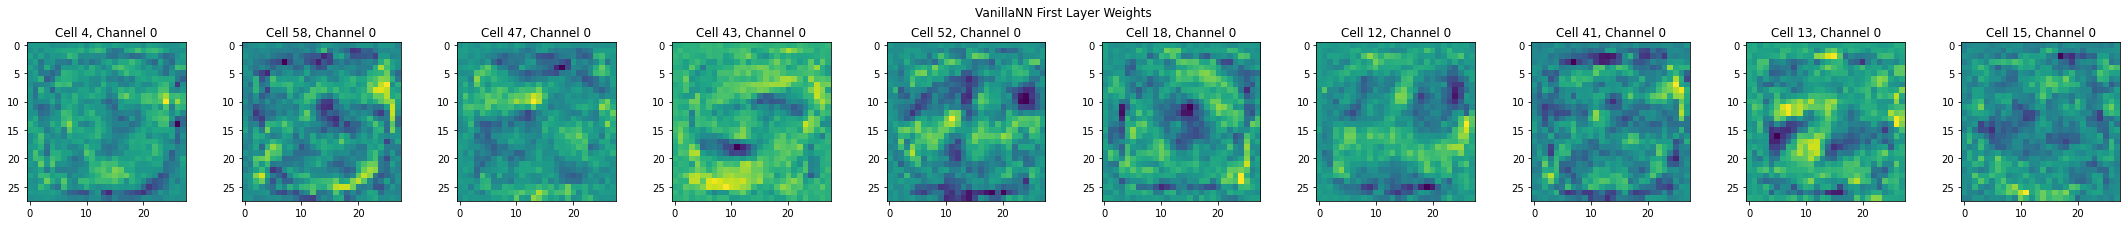

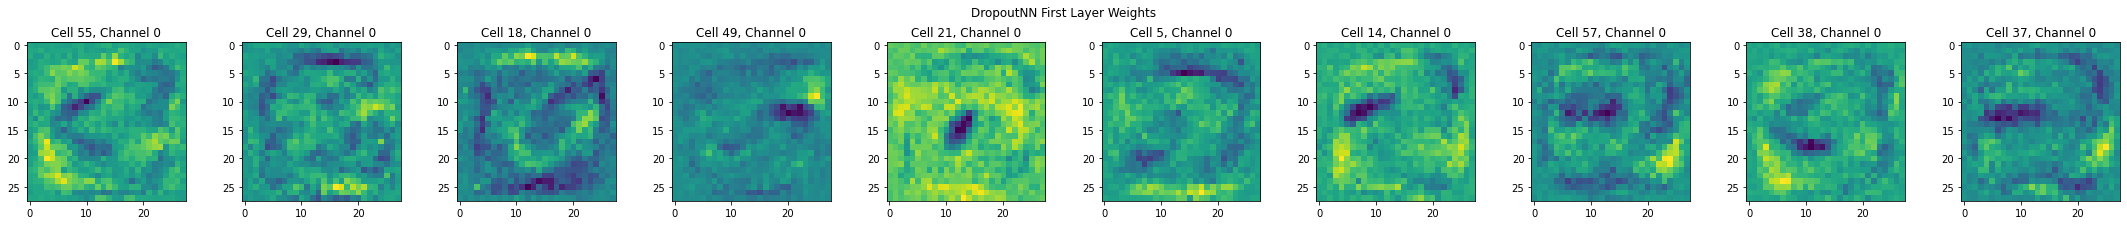

In [17]:
%matplotlib inline

d, h, w = dataset[0][0].shape
plot_first_hidden_layer(vnn, "VanillaNN First Layer Weights", h, w, d)
plot_first_hidden_layer(dnn, "DropoutNN First Layer Weights", h, w, d)

Double click on each row of plots to make them larger!

**TODO: Are there visual differences between the vanilla and dropout model weights? How does dropout cause these differences in the weights?**


It looks like you can more clearly see numbers in the dropout weights whereas the vanilla looks kind of noisy.

# Optimal Images 

Below, we choose random individual neurons from the 'vanilla' net and the dropout net. For each neuron, we train an optimal image to maximally activate its neuron, then display the optimal image.

In [18]:
def generate_optimal_image(
    model: nn.Module,
    run_through_layers: int,
    nodes: int,
    width: int,
    height: int,
    depth: int,
    device,
    learning_rate: int = 5e-4,
    epochs: int = 4500,
    optimize_range: bool = False
) -> np.ndarray:
    # Put model in evaluation mode, we only want to optimize the image...
    model.eval()
    # Create a random image...
    img = torch.randn(1, depth, height, width, device=device, requires_grad=True)
    optimizer = optim.Adam([img], lr=learning_rate)
    loss_func = nn.MSELoss()
    
    print(f"Optimize Values After Layer {model.linear_layer(run_through_layers - 1)}, Node: {nodes}")
    
    for i in range(epochs):
        # Zero gradients...
        if img.grad is not None:
            img.grad.detach_()
            img.grad.zero_()
        model.zero_grad()
        # Run model...
        predicted = model.forward(img, run_through_layers)
        
        mask = np.zeros(predicted.shape[1], bool)
        mask[nodes] = 1
        
        node_score = torch.min(predicted[0, mask])
        not_node_score = torch.max(predicted[0, ~mask])
        
        # Compute loss, backpropigate, and optimize the weights...
        # Our loss: Maximize the range between nodes of interest and other nodes
        loss = -node_score if(not optimize_range) else -node_score + not_node_score
        
        loss.backward()
        optimizer.step()
        
        # All images are made up of channels that range from 0 to 1, so clamp values within that range...
        with torch.no_grad():
            img.clamp_(0, 1)

        if((i % 500 == 0) or (i == (epochs - 1))):
            print(f"Epoch: {i}/{epochs}, Loss: {loss:.02f}")
            
    return img

def random_optimal_images_from(
    model: nn.Module, 
    layer: int, 
    num_samples: int,
    width: int, 
    height: int, 
    depth: int, 
    device,
    *args,
    **kwargs
) -> tuple:
    imgs = []
    samples = np.random.choice(model.linear_layer(layer - 1).weight.shape[0], num_samples, replace=False)
    %matplotlib notebook
    
    for i, sample in enumerate(samples):
        print(f"Working on image {i + 1}/{num_samples}")
        imgs.append(
            generate_optimal_image(model, layer, sample, height, width, depth, device, *args, **kwargs)
        )
    
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(type(model).__name__)
    
    for img, sample_i, sub_axs in zip(imgs, samples, axs.T):
        for j, ax in enumerate(sub_axs):
            img2 = img.cpu().detach().numpy()[0, j]
            ax.set_title(f"Layer {layer}, Node {sample_i}, Channel {j}")
            m = ax.imshow(img2, cmap="plasma") 
    
    fig.colorbar(m)
    fig.tight_layout()
    fig.show()
    
    return fig, axs, imgs, samples

Working on image 1/10
Optimize Values After Layer Linear(in_features=60, out_features=10, bias=True), Node: 5
Epoch: 0/4500, Loss: 38.58
Epoch: 500/4500, Loss: -48.36
Epoch: 1000/4500, Loss: -80.98
Epoch: 1500/4500, Loss: -109.89
Epoch: 2000/4500, Loss: -140.02
Epoch: 2500/4500, Loss: -156.72
Epoch: 3000/4500, Loss: -164.92
Epoch: 3500/4500, Loss: -170.49
Epoch: 4000/4500, Loss: -174.19
Epoch: 4499/4500, Loss: -176.81
Working on image 2/10
Optimize Values After Layer Linear(in_features=60, out_features=10, bias=True), Node: 2
Epoch: 0/4500, Loss: 20.73
Epoch: 500/4500, Loss: -35.01
Epoch: 1000/4500, Loss: -120.26
Epoch: 1500/4500, Loss: -177.81
Epoch: 2000/4500, Loss: -229.24
Epoch: 2500/4500, Loss: -244.97
Epoch: 3000/4500, Loss: -250.19
Epoch: 3500/4500, Loss: -252.62
Epoch: 4000/4500, Loss: -253.88
Epoch: 4499/4500, Loss: -254.45
Working on image 3/10
Optimize Values After Layer Linear(in_features=60, out_features=10, bias=True), Node: 0
Epoch: 0/4500, Loss: 48.33
Epoch: 500/4500, L

<IPython.core.display.Javascript object>


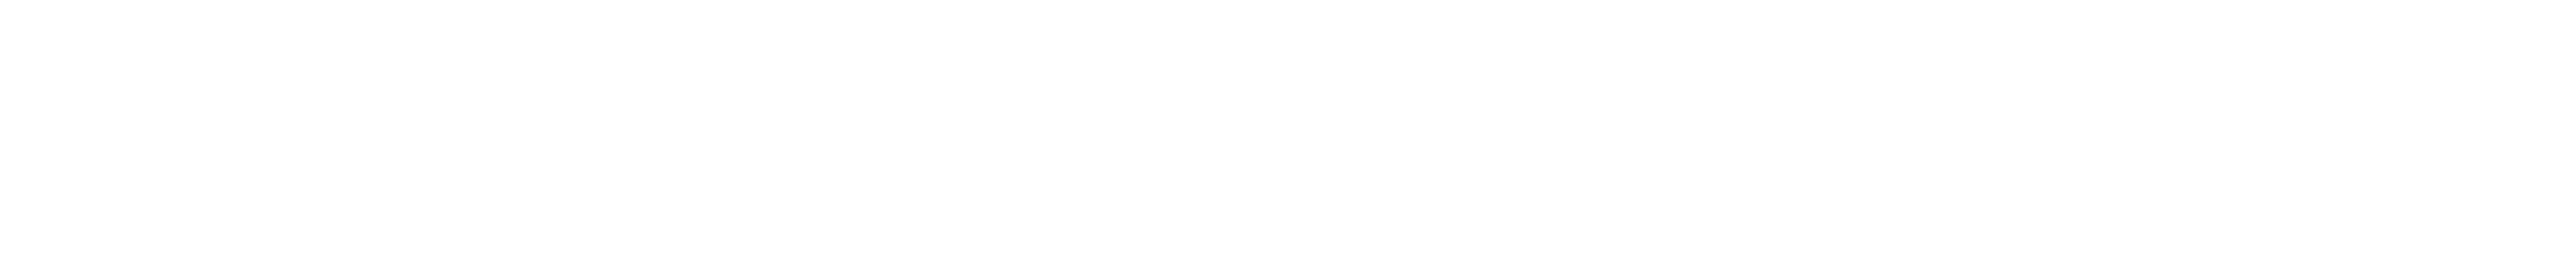

Working on image 1/10
Optimize Values After Layer Linear(in_features=60, out_features=10, bias=True), Node: 4
Epoch: 0/4500, Loss: 23.70
Epoch: 500/4500, Loss: 10.12
Epoch: 1000/4500, Loss: 0.39
Epoch: 1500/4500, Loss: -19.90
Epoch: 2000/4500, Loss: -235.05
Epoch: 2500/4500, Loss: -306.49
Epoch: 3000/4500, Loss: -332.00
Epoch: 3500/4500, Loss: -341.95
Epoch: 4000/4500, Loss: -347.04
Epoch: 4499/4500, Loss: -349.32
Working on image 2/10
Optimize Values After Layer Linear(in_features=60, out_features=10, bias=True), Node: 1
Epoch: 0/4500, Loss: 232.32
Epoch: 500/4500, Loss: 1.98
Epoch: 1000/4500, Loss: 1.07
Epoch: 1500/4500, Loss: -0.86
Epoch: 2000/4500, Loss: -2.16
Epoch: 2500/4500, Loss: -3.05
Epoch: 3000/4500, Loss: -3.88
Epoch: 3500/4500, Loss: -4.55
Epoch: 4000/4500, Loss: -4.97
Epoch: 4499/4500, Loss: -6.55
Working on image 3/10
Optimize Values After Layer Linear(in_features=60, out_features=10, bias=True), Node: 8
Epoch: 0/4500, Loss: 188.25
Epoch: 500/4500, Loss: -14.85
Epoch: 10

<IPython.core.display.Javascript object>


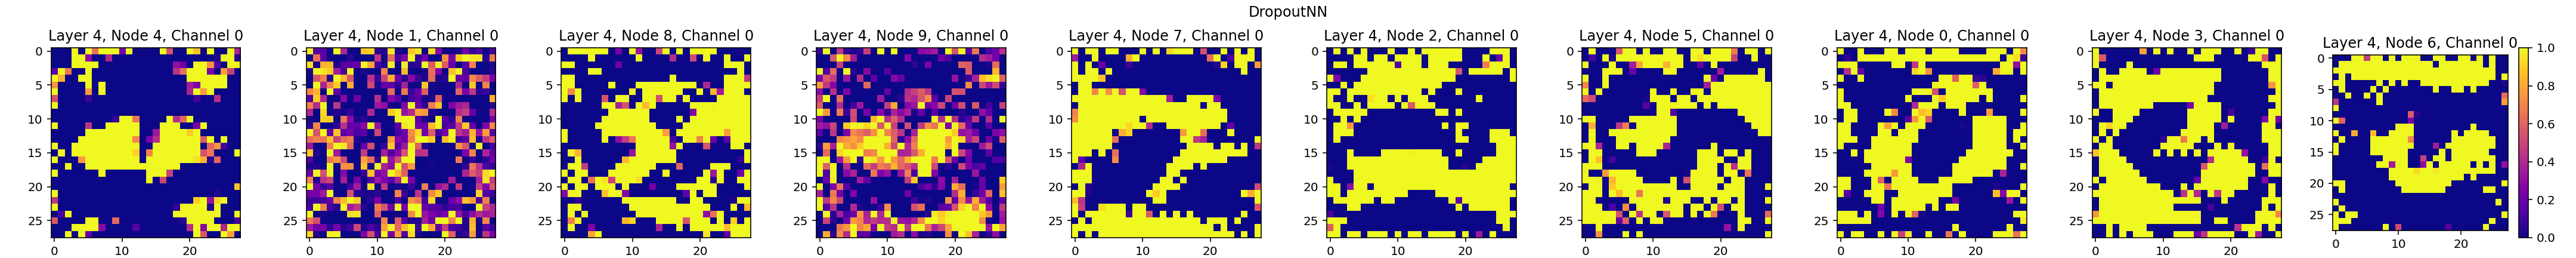

In [24]:
%matplotlib inline
vanilla_res_4 = random_optimal_images_from(vnn, 4, 10, h, w, d, device, optimize_range=True)[0]
dropout_res_4 = random_optimal_images_from(dnn, 4, 10, h, w, d, device, optimize_range=True)[0]

<IPython.core.display.Javascript object>


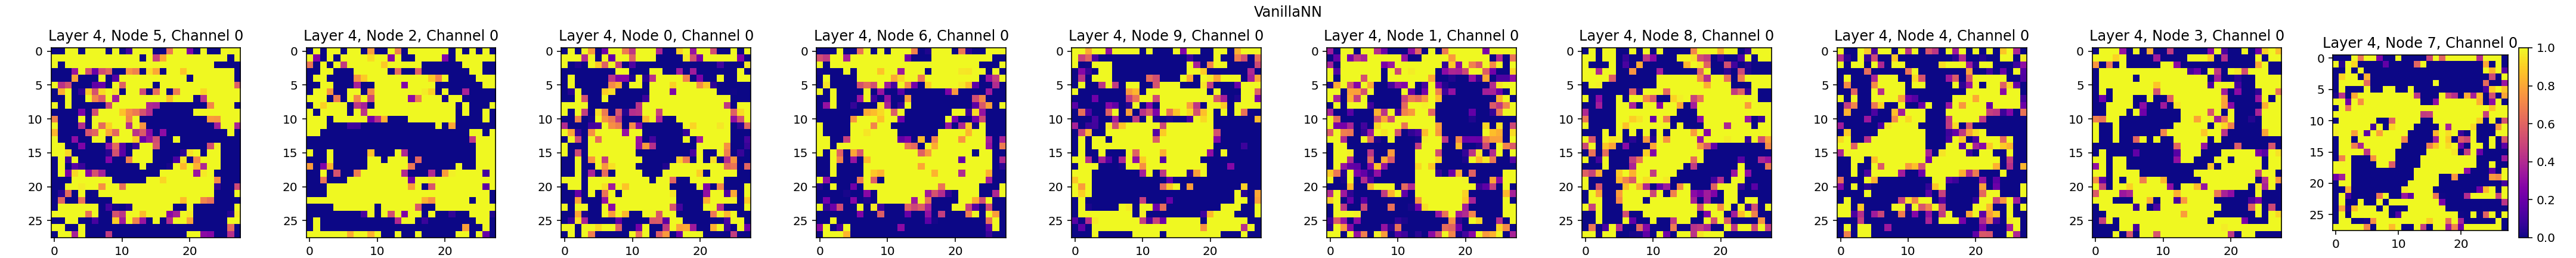

In [25]:
%matplotlib inline
vanilla_res_4

<IPython.core.display.Javascript object>


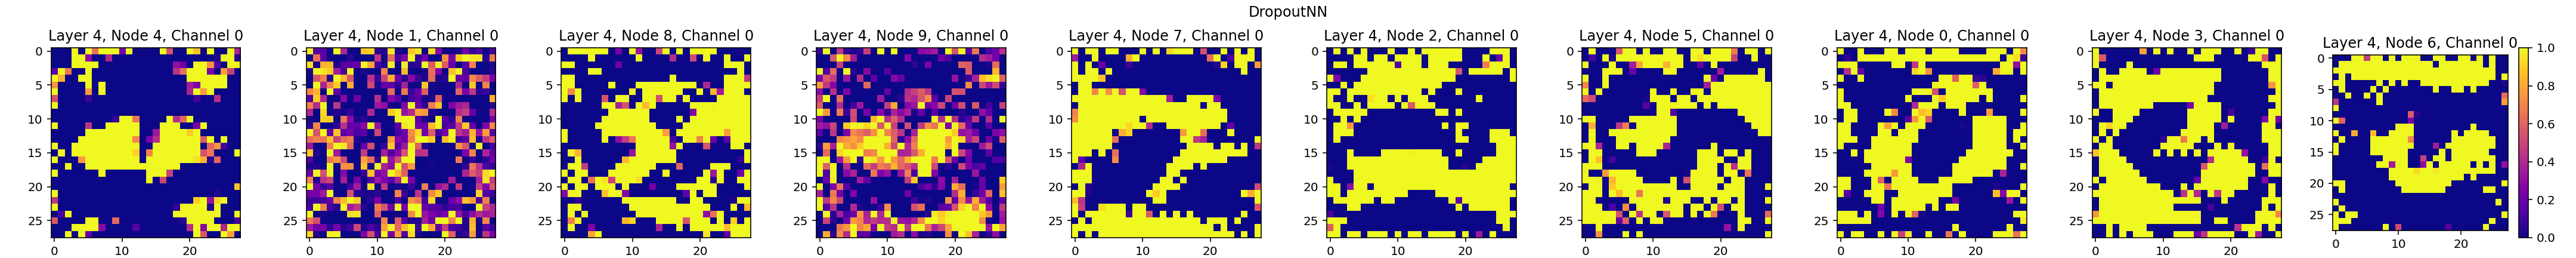

In [26]:
%matplotlib inline
dropout_res_4

**TODO: Are there any differences between the 'vanilla' net optimal images and the dropout net optimal images? If so, what do you think led to these differences?**

I don't see big differences between the vanilla and dropout optimal images. The vanilla is potentially a bit noiser (pixels are more spread out) which means the nodes in the vanilla net are likely to be less focused on specific areas and more general. 

**TODO: The above function allows you to randomly sample nodes from any layer of the network for generating optimal images (Currently set to layer 4, the final layer output). What results do you get when changing the layer optimal images are being generated for? How do the Vanilla NN and Dropout NN results compare and differ?**


Looking at layers 1 and 3, the first layer in both starts very noisy and more distinct features are found as you move towards the final layer. It's still hard for me to visually see differences between the vanilla and dropout, especially when the vanilla md

Working on image 1/3
Optimize Values After Layer Linear(in_features=784, out_features=60, bias=True), Node: 56
Epoch: 0/4500, Loss: 7.91
Epoch: 500/4500, Loss: -1.76
Epoch: 1000/4500, Loss: -7.12
Epoch: 1500/4500, Loss: -11.55
Epoch: 2000/4500, Loss: -15.29
Epoch: 2500/4500, Loss: -17.56
Epoch: 3000/4500, Loss: -18.65
Epoch: 3500/4500, Loss: -19.19
Epoch: 4000/4500, Loss: -19.51
Epoch: 4499/4500, Loss: -19.73
Working on image 2/3
Optimize Values After Layer Linear(in_features=784, out_features=60, bias=True), Node: 20
Epoch: 0/4500, Loss: 6.06
Epoch: 500/4500, Loss: 3.91
Epoch: 1000/4500, Loss: -0.25
Epoch: 1500/4500, Loss: -6.33
Epoch: 2000/4500, Loss: -10.04
Epoch: 2500/4500, Loss: -12.56
Epoch: 3000/4500, Loss: -14.43
Epoch: 3500/4500, Loss: -15.59
Epoch: 4000/4500, Loss: -16.26
Epoch: 4499/4500, Loss: -16.71
Working on image 3/3
Optimize Values After Layer Linear(in_features=784, out_features=60, bias=True), Node: 8
Epoch: 0/4500, Loss: 9.17
Epoch: 500/4500, Loss: 3.72
Epoch: 1000/

<IPython.core.display.Javascript object>


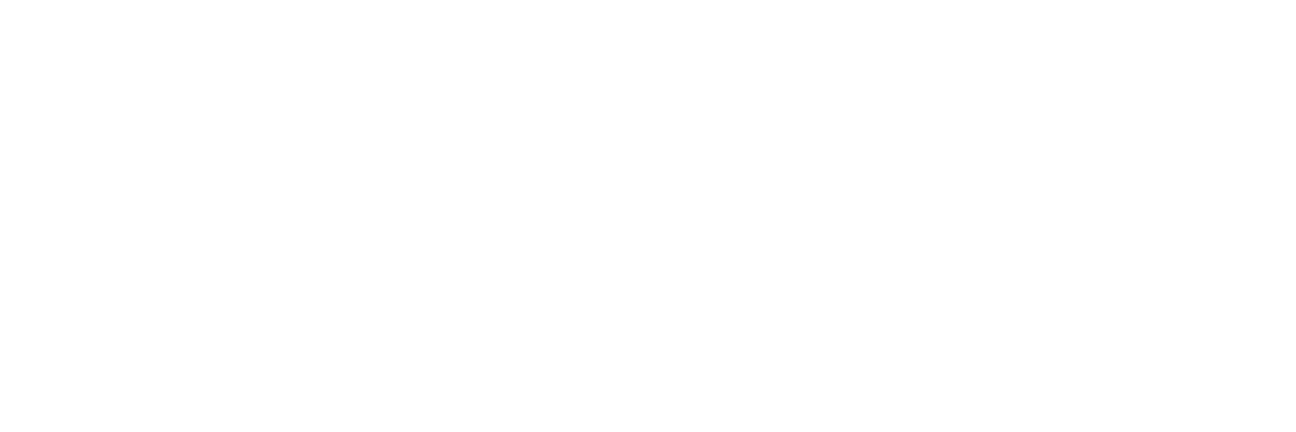

Working on image 1/3
Optimize Values After Layer Linear(in_features=784, out_features=60, bias=True), Node: 2
Epoch: 0/4500, Loss: 5.68
Epoch: 500/4500, Loss: 0.04
Epoch: 1000/4500, Loss: 0.03
Epoch: 1500/4500, Loss: 0.02
Epoch: 2000/4500, Loss: 0.01
Epoch: 2500/4500, Loss: 0.00
Epoch: 3000/4500, Loss: -0.01
Epoch: 3500/4500, Loss: -11.74
Epoch: 4000/4500, Loss: -15.83
Epoch: 4499/4500, Loss: -17.29
Working on image 2/3
Optimize Values After Layer Linear(in_features=784, out_features=60, bias=True), Node: 30
Epoch: 0/4500, Loss: 4.80
Epoch: 500/4500, Loss: 0.03
Epoch: 1000/4500, Loss: 0.02
Epoch: 1500/4500, Loss: 0.02
Epoch: 2000/4500, Loss: 0.01
Epoch: 2500/4500, Loss: 0.01
Epoch: 3000/4500, Loss: -0.00
Epoch: 3500/4500, Loss: -10.64
Epoch: 4000/4500, Loss: -14.57
Epoch: 4499/4500, Loss: -16.26
Working on image 3/3
Optimize Values After Layer Linear(in_features=784, out_features=60, bias=True), Node: 51
Epoch: 0/4500, Loss: 1.74
Epoch: 500/4500, Loss: -7.10
Epoch: 1000/4500, Loss: -12

<IPython.core.display.Javascript object>


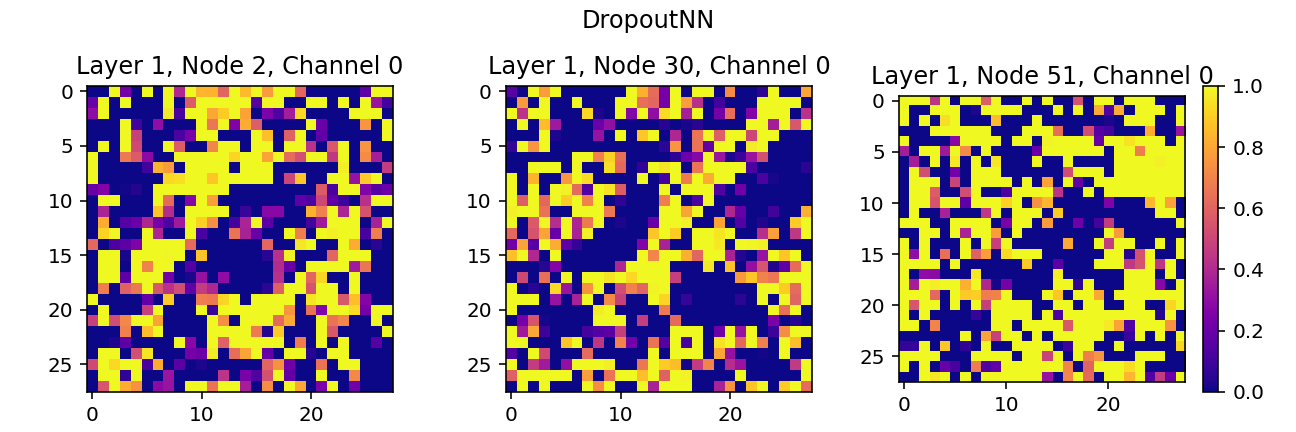

In [27]:
vanilla_res_1 = random_optimal_images_from(vnn, 1, 3, h, w, d, device, optimize_range=True)[0]
dropout_res_1 = random_optimal_images_from(dnn, 1, 3, h, w, d, device, optimize_range=True)[0]

<IPython.core.display.Javascript object>


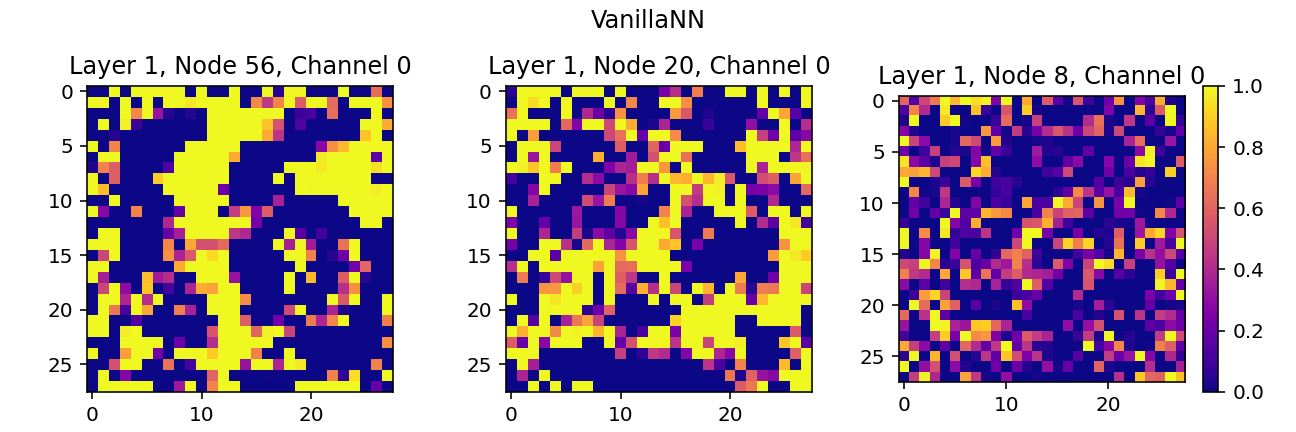

In [28]:
%matplotlib inline
vanilla_res_1

<IPython.core.display.Javascript object>


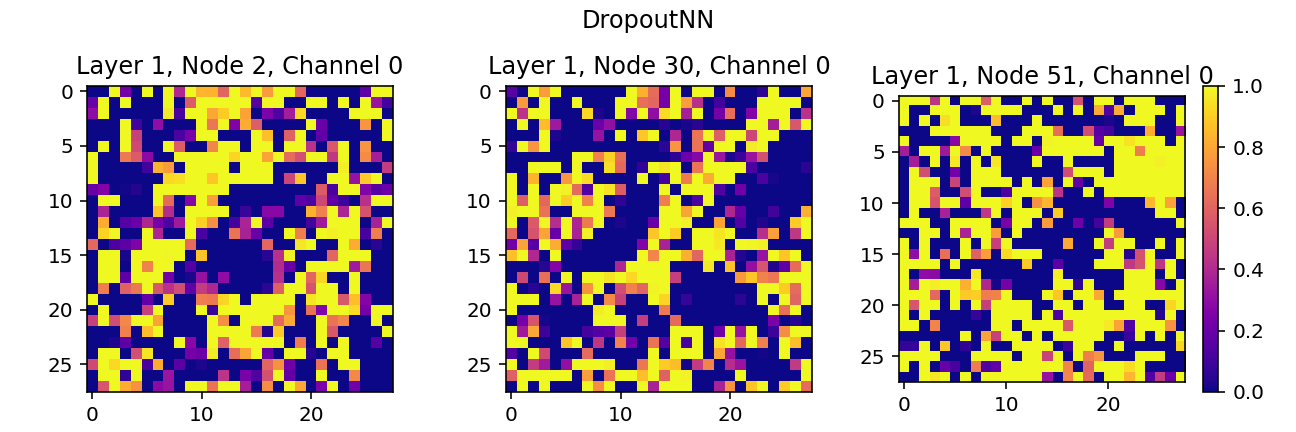

In [29]:
%matplotlib inline
dropout_res_1

Working on image 1/3
Optimize Values After Layer Linear(in_features=60, out_features=60, bias=True), Node: 44
Epoch: 0/4500, Loss: 17.73
Epoch: 500/4500, Loss: 0.87
Epoch: 1000/4500, Loss: 0.06
Epoch: 1500/4500, Loss: -0.38
Epoch: 2000/4500, Loss: -0.78
Epoch: 2500/4500, Loss: -1.33
Epoch: 3000/4500, Loss: -1.83
Epoch: 3500/4500, Loss: -2.34
Epoch: 4000/4500, Loss: -2.78
Epoch: 4499/4500, Loss: -3.18
Working on image 2/3
Optimize Values After Layer Linear(in_features=60, out_features=60, bias=True), Node: 50
Epoch: 0/4500, Loss: 5.40
Epoch: 500/4500, Loss: -4.69
Epoch: 1000/4500, Loss: -6.80
Epoch: 1500/4500, Loss: -8.85
Epoch: 2000/4500, Loss: -10.79
Epoch: 2500/4500, Loss: -12.49
Epoch: 3000/4500, Loss: -13.87
Epoch: 3500/4500, Loss: -14.93
Epoch: 4000/4500, Loss: -15.74
Epoch: 4499/4500, Loss: -16.33
Working on image 3/3
Optimize Values After Layer Linear(in_features=60, out_features=60, bias=True), Node: 47
Epoch: 0/4500, Loss: 5.73
Epoch: 500/4500, Loss: -5.47
Epoch: 1000/4500, Lo

<IPython.core.display.Javascript object>


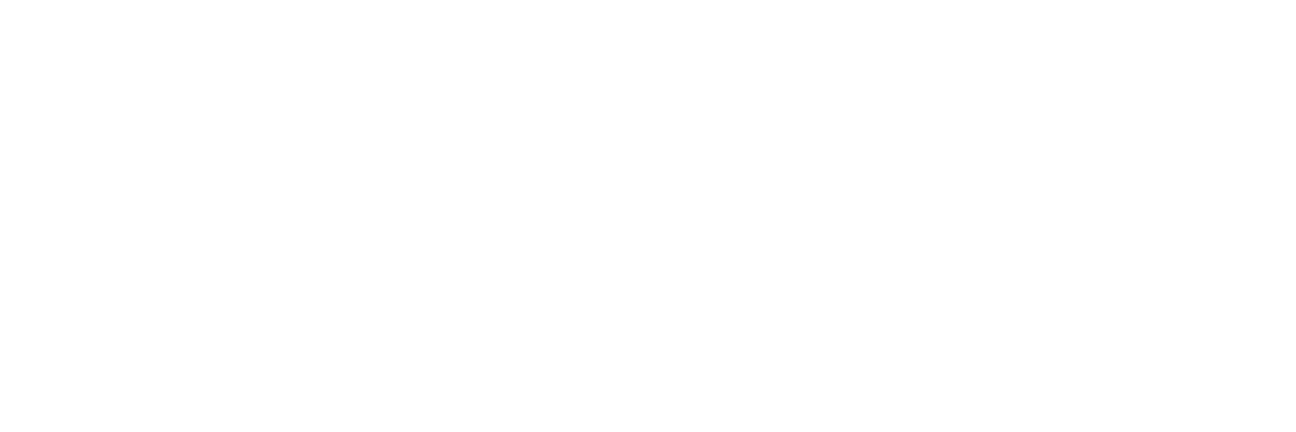

Working on image 1/3
Optimize Values After Layer Linear(in_features=60, out_features=60, bias=True), Node: 0
Epoch: 0/4500, Loss: 27.60
Epoch: 500/4500, Loss: 1.25
Epoch: 1000/4500, Loss: 0.49
Epoch: 1500/4500, Loss: 0.40
Epoch: 2000/4500, Loss: 0.37
Epoch: 2500/4500, Loss: 0.35
Epoch: 3000/4500, Loss: 0.33
Epoch: 3500/4500, Loss: 0.31
Epoch: 4000/4500, Loss: 0.31
Epoch: 4499/4500, Loss: 0.30
Working on image 2/3
Optimize Values After Layer Linear(in_features=60, out_features=60, bias=True), Node: 26
Epoch: 0/4500, Loss: 26.88
Epoch: 500/4500, Loss: 1.11
Epoch: 1000/4500, Loss: 0.99
Epoch: 1500/4500, Loss: 0.93
Epoch: 2000/4500, Loss: 0.88
Epoch: 2500/4500, Loss: 0.83
Epoch: 3000/4500, Loss: 0.78
Epoch: 3500/4500, Loss: 0.76
Epoch: 4000/4500, Loss: 0.74
Epoch: 4499/4500, Loss: 0.73
Working on image 3/3
Optimize Values After Layer Linear(in_features=60, out_features=60, bias=True), Node: 12
Epoch: 0/4500, Loss: 43.29
Epoch: 500/4500, Loss: 0.20
Epoch: 1000/4500, Loss: 0.15
Epoch: 1500/4

<IPython.core.display.Javascript object>


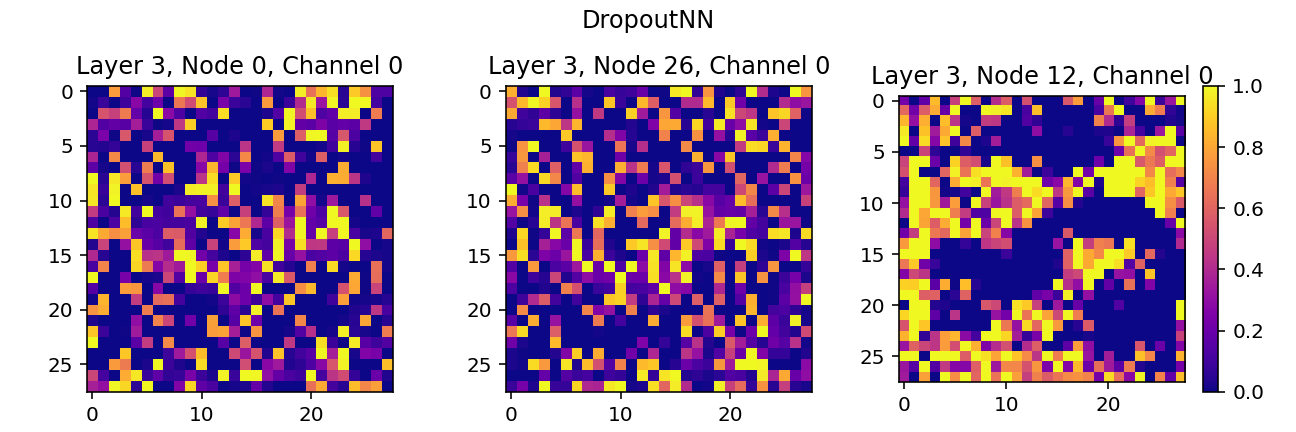

In [30]:
vanilla_res_3 = random_optimal_images_from(vnn, 3, 3, h, w, d, device, optimize_range=True)[0]
dropout_res_3 = random_optimal_images_from(dnn, 3, 3, h, w, d, device, optimize_range=True)[0]

<IPython.core.display.Javascript object>


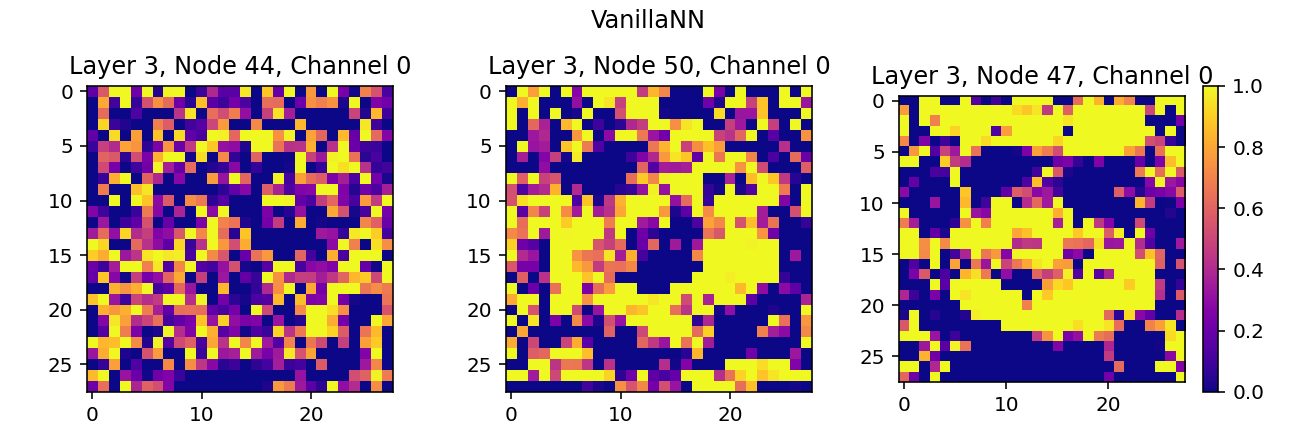

In [31]:
%matplotlib inline
vanilla_res_3

<IPython.core.display.Javascript object>


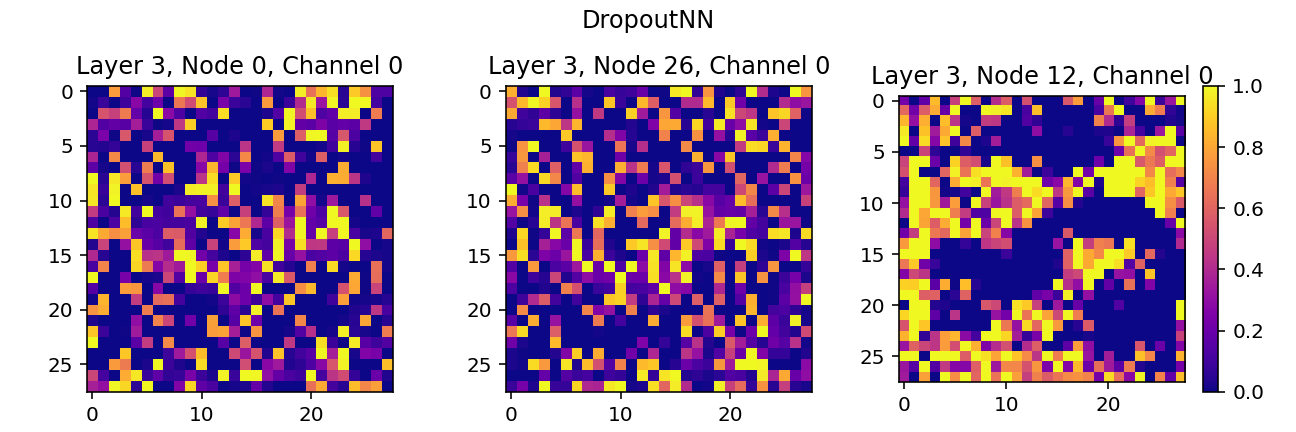

In [32]:
%matplotlib inline
dropout_res_3